In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [54]:
dataset = 'BigEarthNet'
# dataset = 'EuroSAT'
dataset = 'So2Sat' 
# dataset = 'OSCD'
models = []
names = []
# models += ['vit_base_patch16_224']
# models += ['cvit_base_patch16_224']
# models += ['cvit_p1_base_patch16_224']
# models += ['mm_cvit_base_patch16_224']
models += ['mm_lr_vit_base_patch16_224']
# names += ['mae_vit_v2']
# names += ['mae_cvit_v2']
# names += ['mae_base']
# names += ['mae_vit_btnk']
metric = 'micro_mAP' if dataset == 'BigEarthNet' else 'accuracy'
if dataset == 'OSCD':
    # metric = 'precision'
    metric = 'f1'
    # metric = 'recall'
extra_kw = ['fast']
extra_kw = ['']

In [55]:
log_path = './results/logs/'
all_logs = os.listdir(log_path)
target_logs = [log for log in all_logs if dataset in log and any([model in log for model in models]) and any([kw in log for kw in extra_kw])]
# print(len(target_logs))
target_logs

['So2Sat_mm_lr_vit_base_patch16_224_mm_lr_vit_0-2-10_fast',
 'So2Sat_mm_lr_vit_base_patch16_224_mm_lr_vit_1-2-9_fast']

In [56]:
df_all = pd.DataFrame()
for target_log in target_logs:
    name = '_'.join(target_log.split('_')[-3:])
    try:
        path = f'./results/logs/{target_log}/ft_metrics.csv'
        df = pd.read_csv(path)
        df.sort_values(by=[metric], inplace=True)
    except:
        continue
    # add model name
    df['model'] = name
    df_all = pd.concat([df_all, df], ignore_index=True)
# df_all.sort_values(by=[metric], inplace=True)
# only keep the results with 20 epochs
df_all = df_all.loc[df_all['epoch'] == 20]
# get the best lr for each model
df_all_best = df_all.loc[df_all.groupby('model')[metric].idxmax()]
print(len(df_all))
df_all_best.sort_values(by=[metric])
# df_all

3


,epochs,lr,weight_decay,ce,loss,accuracy,epoch,num_samples,model
2,20,0.0004,0.0005,1.873367,1.873367,0.641336,20,48307,vit_1-2-9_fast


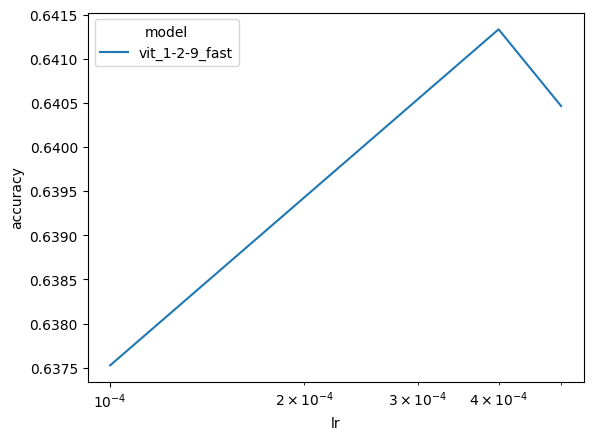

In [57]:
sns.lineplot(data=df_all.loc[df_all.weight_decay==5e-4], x='lr', y=metric, hue='model')
# set x axis log scale
plt.xscale('log')

In [40]:
df_all = pd.DataFrame()
for target_log in target_logs:
    name = '_'.join(target_log.split('_')[-3:])
    try:
        path = f'./results/logs/{target_log}/lp_metrics.csv'
        df = pd.read_csv(path)
        df.sort_values(by=[metric], inplace=True)
    except:
        continue
    # add model name
    df['model'] = name
    df_all = pd.concat([df_all, df], ignore_index=True)
# df_all.sort_values(by=[metric], inplace=True)
# get the best lr for each model
df_all_best = df_all.loc[df_all.groupby('model')[metric].idxmax()]
df_all
df_all_best.sort_values(by=[metric])

,epochs,lr,weight_decay,ce,loss,accuracy,epoch,num_samples,model
1,100,0.10,0.0,1.312274,1.312274,0.583828,100,48307,vit_0-2-10_fast
8,100,0.09,0.0,1.290603,1.290603,0.596021,100,48307,vit_1-2-9_fast


<Axes: xlabel='lr', ylabel='accuracy'>

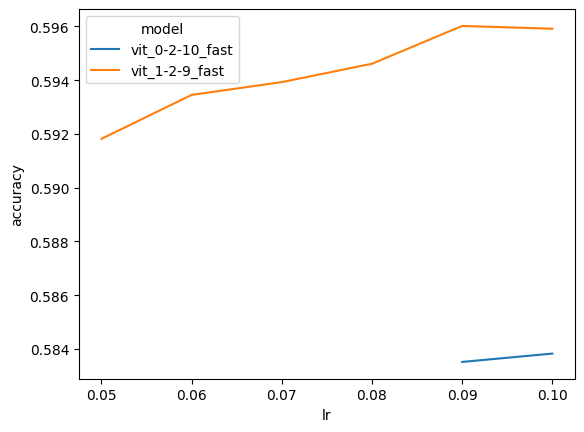

In [41]:
sns.lineplot(data=df_all.loc[df_all.epochs==100], x='lr', y=metric, hue='model')

In [19]:
# parse the model name in the df_all_best
df = df_all_best.copy()
df['model'] = df['model'].apply(lambda x: x.split('_')[-1])
df['spectral'] = df['model'].apply(lambda x: x.split('-')[0])
df['spatial_spectral'] = df['model'].apply(lambda x: x.split('-')[1])
df[metric] *= 100

IndexError: list index out of range

In [ ]:
# drop the heatmap of df_all_best_cvit, x: spatial_spectral, y: spectral, hue: metric
df_attn = df.pivot(index='spectral', columns='spatial_spectral', values=metric)
column_order = ['0', '1', '2', '4', '12']  # replace with your desired order
df_attn = df_attn.reindex(column_order, axis=1)
sns.heatmap(df_attn, annot=True, fmt=".2f", cmap='crest', linewidth=.5, vmin=60.5)
plt.title(f'{dataset} LP {metric} (%)')

KeyError: 'spatial_spectral'

In [22]:
df_all_best_cvit.pivot()

TypeError: DataFrame.pivot() takes 1 positional argument but 2 were given